In [1]:
import ast_preprocess_dataloader
from ast_preprocess_dataloader import AudioPipeline
import torch
import os
import glob
from torch.utils.data import Dataset, DataLoader
from audiomentations import Compose, TimeStretch, PitchShift, HighPassFilter, LowPassFilter, BandPassFilter
import numpy as np
from transformers import AutoProcessor, ASTConfig, ASTModel
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa
import torch.nn.functional as F

C:\Users\dave\anaconda3\envs\haikoo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU 🟢")
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU 🟡")

PyTorch is using GPU 🟢


In [3]:
dataset_dir = r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\orig_resample"
os.path.exists(dataset_dir)

True

In [4]:
class_name = os.listdir(dataset_dir)
class_name

['bellypain', 'discomfort', 'hungry', 'tired']

In [5]:
audio_dir = [os.path.join(dataset_dir, name) for name in class_name]
audio_dir

['C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\bellypain',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\discomfort',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\hungry',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\tired']

In [6]:
bpain_audio = glob.glob(os.path.join(audio_dir[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_dir[3], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_dir[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_dir[1], '*.wav'))

In [7]:
len(hungry_audio)

50

In [8]:
audio_path_class = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

In [9]:
all_paths = []
all_labels = []

for (label, class_name), path_lst in zip(enumerate(audio_path_class), audio_path_class.values()):
    for path in path_lst:
        all_paths.append(path)
        all_labels.append(label)

In [10]:
from collections import Counter

Counter(all_labels)

Counter({1: 50, 2: 50, 0: 49, 3: 48})

## **훈련, 검증, 테스트 경로 쪼개기**

In [11]:
train_paths, val_paths, train_labels, val_labels = train_test_split(all_paths, all_labels, test_size=0.3, random_state=42)

In [12]:
# 갯수 확인
print(len(train_paths))
print(len(val_paths))
print(len(train_labels))
print(len(val_labels))

137
60
137
60


In [13]:
val_paths, test_paths, val_labels, test_labels = train_test_split(val_paths, val_labels, test_size=0.5, random_state=42)

In [14]:
# 갯수 확인
print(len(val_paths))
print(len(test_paths))
print(len(val_labels))
print(len(test_labels))

30
30
30
30


## **파이프라인 만들기**

In [15]:
augmentations = Compose([
    BandPassFilter(min_center_freq=1500, max_center_freq=1500,
                   max_bandwidth_fraction=0.8, min_bandwidth_fraction=0.8,
                   max_rolloff=12, min_rolloff=12, p=1.0)
])

train_dataset = AudioPipeline(audio_paths=train_paths, audio_labels=train_labels, sr=20000, transform=augmentations)
val_dataset = AudioPipeline(audio_paths=val_paths, audio_labels=val_labels, sr=20000)
test_dataset = AudioPipeline(audio_paths=val_paths, audio_labels=val_labels, sr=20000)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be remo

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

## **모델 불러오기**

In [17]:
class CustomASTClassifier(nn.Module):
    def __init__(self, ast_model_name, num_labels):
        super().__init__()
        # self.astconfig = ASTConfig() # 괄호 안에 configuration 값 넣어주면 됩니다. 아마 sampling rate도 20000으로 맞춰주시면 될 것 같아요.
        self.ast = ASTModel.from_pretrained(ast_model_name) # 요거 안되면 질문주세요
        self.num_labels = num_labels
        for param in self.ast.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(140, 4)
        self.dense1 = nn.Linear(932352, 280)
        self.dense2 = nn.Linear(280, 140)
        self.activation = nn.GELU()

    def forward(self, input_values, labels=None):
        input_values = input_values.float()
        outputs = self.ast(input_values)
        embeddings = outputs.last_hidden_state
        # embeddings = torch.transpose(embeddings, 2, 1)
        flat_embed = embeddings.reshape(embeddings.shape[0], -1)
        x = self.dense1(flat_embed)
        x = self.activation(x)
        x = self.dense2(x)
        x = self.activation(x)
        logits = self.classifier(x)
        
        # if labels is not None:
        #     loss_fct = nn.CrossEntropyLoss()
        #     loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1).long())
        #     return loss, logits
        return logits

## **위 코드 적용하는 법**
```python
class CustomASTClassifier(nn.Module):
    def __init__(self, ast_model_name, num_labels):
        super().__init__()
        self.ast = ASTModel.from_pretrained(ast_model_name) 
        self.num_labels = num_labels
        for param in self.ast.parameters():
            param.requires_grad = False
        
        # 요 아래부분만 모델 구조 바꾸시면 되요 CNN이든 DNN이든 맞춰서 해주시면 됩니다.
        # 아래는 예시입니다.
        self.classifier = nn.Linear(140, 4)
        self.dense1 = nn.Linear(932352, 280)
        self.dense2 = nn.Linear(280, 140)
        self.activation = nn.GELU()

    def forward(self, input_values, labels=None):
        input_values = input_values.float()
        outputs = self.ast(input_values)
        embeddings = outputs.last_hidden_state
        # embeddings = torch.transpose(embeddings, 2, 1)

        # 요 아래 Feed Forward 나 CNN Feed Forward는 맞춰서 데이터 흘려보내면 됩니다. 아래는 예시입니다.
        flat_embed = embeddings.reshape(embeddings.shape[0], -1)
        x = self.dense1(flat_embed)
        x = self.activation(x)
        x = self.dense2(x)
        x = self.activation(x)
        logits = self.classifier(x)
        
        return logits
```

In [18]:
num_labels = 4
ast_model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
model = CustomASTClassifier(ast_model_name, num_labels).to(device)

# Define your optimizer, loss function, etc.
# optimizer = optim.Adam(model.parameters(), lr=1e-04)
ast_loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
# 여기서 ast 모델이 다 freeze 됐는지 확인하시면 되요
for name, param in model.ast.named_parameters():
    if param.requires_grad:
        print(f"{name}: requires_grad is True")
    else:
        print(f"{name}: requires_grad is False")

embeddings.cls_token: requires_grad is False
embeddings.distillation_token: requires_grad is False
embeddings.position_embeddings: requires_grad is False
embeddings.patch_embeddings.projection.weight: requires_grad is False
embeddings.patch_embeddings.projection.bias: requires_grad is False
encoder.layer.0.attention.attention.query.weight: requires_grad is False
encoder.layer.0.attention.attention.query.bias: requires_grad is False
encoder.layer.0.attention.attention.key.weight: requires_grad is False
encoder.layer.0.attention.attention.key.bias: requires_grad is False
encoder.layer.0.attention.attention.value.weight: requires_grad is False
encoder.layer.0.attention.attention.value.bias: requires_grad is False
encoder.layer.0.attention.output.dense.weight: requires_grad is False
encoder.layer.0.attention.output.dense.bias: requires_grad is False
encoder.layer.0.intermediate.dense.weight: requires_grad is False
encoder.layer.0.intermediate.dense.bias: requires_grad is False
encoder.laye

In [20]:
# 요 코드는 그래로 나두고 lr_init만 바꿔서 체크하면 되요.
def find_learning_rate(model, train_loader, loss_fn, device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    lr_find_loss = []
    lr_find_lr = []

    lr_init = 1e-8 # <<<< 요기만 바꾸면됨
    lr_final = 1e-2
    n_steps = 100
    current_lr = lr_init
    lr_increment = (lr_final / lr_init) ** (1/n_steps)

    model.train()  # Set model to training mode

    for batch_idx, batch in enumerate(train_loader):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.param_groups[0]['lr'] = current_lr
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lr_find_loss.append(loss.item())
        lr_find_lr.append(current_lr)

        current_lr *= lr_increment
        if current_lr > lr_final:
            break

    plt.plot(lr_find_lr, lr_find_loss)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.show()
    return lr_find_lr, lr_find_loss


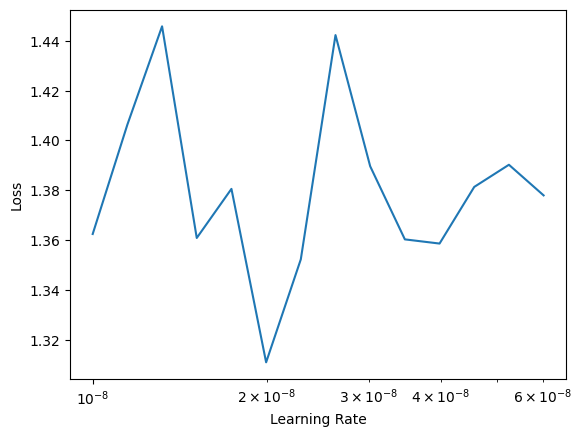

([1e-08,
  1.1481536214968828e-08,
  1.3182567385564073e-08,
  1.5135612484362086e-08,
  1.737800828749376e-08,
  1.9952623149688803e-08,
  2.290867652767774e-08,
  2.630267991895383e-08,
  3.0199517204020175e-08,
  3.467368504525318e-08,
  3.981071705534974e-08,
  4.5708818961487524e-08,
  5.2480746024977285e-08,
  6.025595860743581e-08],
 [1.3625112771987915,
  1.4063618183135986,
  1.4457623958587646,
  1.3609215021133423,
  1.3806021213531494,
  1.3110750913619995,
  1.3523600101470947,
  1.4422500133514404,
  1.3896666765213013,
  1.3603582382202148,
  1.3586817979812622,
  1.381385087966919,
  1.3902699947357178,
  1.3779951333999634])

In [21]:
find_learning_rate(model, train_dataloader, ast_loss_fn, device=device)

## **결과 보는 법**

- 우선 그래프를 먼저 보면 loss가 가장 낮은 learning rate를 눈으로 확인할 수 있음.
- 그리고 tuple 안에 두 개의 리스트가 있는데 첫번째 리스트는 learning rate이고 두 번째 리스트는 loss 값
- 제일 낮은 loss를 찾아서 해당되는 learning rate를 쓰면 됨